## In this notebook, I'll try Vanilla encoder-decoder model as a baseline model for my CHATBOT

## Overview
***
*A chatbot or chatterbot is a software application used to conduct an on-line chat conversation via text or text-to-speech, in lieu of providing direct contact with a live human agent chatbot is a type of software that can help human by automating conversations and interact with them through messaging platforms. here are different approaches and tools that you can use when building chatbots. Depending on the use case you want to address, some technologies are more appropriate than others. Combining artificial intelligence forms such as natural language processing, machine learning, and semantic understanding may be the best option to achieve the desired results.*
***


## How to build a Chatbot for our task?
***
ChatBots are usually Task specific means if there a chatbot which serves only food delivery app have trained on a dataset which
completely different from the dataset on which chatbot which serves online healthcare app. Similary, for this kaggle problem
we have provided with movie dataset which may feel that its not specific to any task, but actually it is specific to how people
will interect generally as these movie dialogues are nothing but daily life conversation between people however, that chatbot
may reply things which sounds too much dramatic and filmy like some dialogue of Tom cruise, shah rukh khan etc.

We can approch this problem by applying Neural network models like encoder-decoder architecture with some attention mechanism.
***

In [4]:
import numpy as np
import codecs
import tensorflow as tf
import pandas as pd
import ast
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import warnings
import joblib
warnings.filterwarnings('ignore')

## Loading data, prepared while EDA and preprocessing

In [17]:
train = joblib.load("train")
validation = joblib.load("validation")

In [18]:
train.head()

,question,answer_in,answer_out
31606,ma i am gonna stay home and watch jackie gleason,<start> you gonna die without a son <end>,you gonna die without a son <end> <end>
34339,this looks like a job for superman,<start> or batman,or batman <end>
32082,thanks good night mrs mitchell,<start> good night john,good night john <end>
109702,the only answer i have for you,<start> you passed up a dozen chances to arres...,you passed up a dozen chances to arrest her w...
26991,lyssa,<start> come quickly colwyn i can see the eyes...,come quickly colwyn i can see the eyes of the ...


In [19]:
validation.head()

,question,answer_in,answer_out
38803,you are lucky she could not come anyway,<start> well i am glad you did not thank you,well i am glad you did not thank you <end>
7194,i think i have no money,<start> it is okay forget it,it is okay forget it <end>
21215,enjoy your last night where is otis,<start> oh he is coming he got something real ...,oh he is coming he got something real special ...
23141,what do you want,<start> nothing,nothing <end>
18195,what is it,<start> i have to pee,i have to pee <end>


####  \<start>, \<end> tokens, for to apply one time-shifted technique!

In [20]:
tknizer_q = Tokenizer(filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_q.fit_on_texts(train['question'].values)
tknizer_a = Tokenizer(filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_a.fit_on_texts(train['answer_in'].values)

In [21]:
q_word_idx = tknizer_q.word_index
q_idx_word = {v: k for k, v in q_word_idx.items()}

a_word_idx = tknizer_a.word_index
a_idx_word = {v: k for k, v in a_word_idx.items()}

print(len(q_word_idx.keys()))
print(len(a_word_idx.keys()))

29704
29595


In [22]:
train['answer_in'].values

array(['<start> you gonna die without a son <end>', '<start> or batman ',
       '<start> good night john', ...,
       '<start> i have retrieved certain pieces of information on miss katarina stratford i think you will find helpful',
       '<start> now you',
       '<start> all kinds of shit would come out like the ellsberg thing  you knew about that henry did not you'],
      dtype=object)

In [23]:
a_word_idx['<start>'], a_word_idx['<end>']

(1, 14863)

In [24]:
vocab_size_a = len(a_word_idx.keys())
vocab_size_q = len(q_word_idx.keys())

In [25]:
class Dataset:
    def __init__(self, data, tknizer_q, tknizer_a):
        self.encoder_inps = data['question'].values
        self.decoder_inps = data['answer_in'].values
        self.decoder_outs = data['answer_out'].values
        self.tknizer_q = tknizer_q
        self.tknizer_a = tknizer_a

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_q.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_a.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_a.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq,maxlen=27, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq,maxlen=27, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq,maxlen=27, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [26]:
train_dataset = Dataset(train, tknizer_q, tknizer_a)
test_dataset  = Dataset(validation, tknizer_q, tknizer_a)
train_dataloader = Dataloder(train_dataset, batch_size=128)
test_dataloader = Dataloder(test_dataset, batch_size=128)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(128, 27) (128, 27) (128, 27)


In [ ]:
# ([q,a_in],a_out), ([q,a_in],a_out), ([q,a_in],a_out) ....

In [35]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''
    def __init__(self, ques_vocab_size, embedding_dim, encoder_input_length, lstm_units):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__(name="encode_model")
        self.ques_vocab_size = ques_vocab_size
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.encoder_input_length = encoder_input_length
        self.embedding = Embedding(input_dim=self.ques_vocab_size, output_dim=self.embedding_dim, input_length=self.encoder_input_length,\
                  mask_zero=True, name="embedding_layer_encoder")
        self.LSTM = LSTM(self.lstm_units, return_state=True, return_sequences=True, name="Encoder_LSTM")

    def call(self,input_sequence):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
        '''
        input_embeddings = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h, self.lstm_state_c = self.LSTM(input_embeddings)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

    
    def initialize_states(self,batch_size):
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        lstm_state_h = tf.zeros([batch_size, self.lstm_size])
        lstm_state_c = tf.zeros([batch_size, self.lstm_size])

        return lstm_state_h, lstm_state_c




In [34]:
class Decoder(tf.keras.Model):
    def __init__(self, ans_vocab_size, embedding_dim, decoder_input_length, lstm_units):
        #Intialize necessary variables and create an object from the class onestepdecoder
        super().__init__(name="Decode_Attention")
        self.ans_vocab_size = ans_vocab_size
        self.embedding_dim = embedding_dim
        self.decoder_input_length = decoder_input_length
        self.lstm_units = lstm_units 
        self.embedding = Embedding(input_dim=self.ans_vocab_size, output_dim=self.embedding_dim,input_length=self.decoder_input_length,\
                  mask_zero=True, trainable=True, name="embedding_layer_decoder")
        self.LSTM = LSTM(self.lstm_units, return_sequences=True, return_state=True, name="Dencoder_LSTM")
        
 
    def call(self,input_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        state_h, state_c = initial_states[0], initial_states[1]
        input_embeddings = self.embedding(input_sequence)
        lstm_output, _, _  = self.LSTM(input_embeddings, initial_state=[state_h, state_c])
        return lstm_output, _, _

    

In [40]:
class encoder_decoder(tf.keras.Model):
    def __init__(self,ques_vocab_size, ans_vocab_size, encoder_input_length, dencoder_input_length, emb_dim, lstm_units):
        #Intialize objects from encoder decoder
        super().__init__(name="Encoder_Decoder_model")
    
        self.encoder = Encoder(ques_vocab_size, emb_dim, encoder_input_length, lstm_units )
        self.decoder = Decoder(ans_vocab_size, emb_dim, dencoder_input_length, lstm_units)
        self.dense   = Dense(ans_vocab_size, activation='softmax')
                             
    def call(self,data):
        #Intialize encoder states, Pass the encoder_sequence to the embedding layer
        # Decoder initial states are encoder final states, Initialize it accordingly
        # Pass the decoder sequence,encoder_output,decoder states to Decoder
        # return the decoder output
        input_q, input_a = data[0], data[1]
        encoder_output, encoder_h, encoder_c = self.encoder(input_q)
        decoder_output, _, _ = self.decoder(input_a, [encoder_h, encoder_c])
        output = self.dense(decoder_output)
        return output
        





In [41]:
ques_vocab_size = vocab_size_q + 1
ans_vocab_size = vocab_size_a + 1
encoder_input_length = 27
dencoder_input_length = 27
lstm_units = 512
emb_dim = 100

model_vanilla = encoder_decoder(ques_vocab_size, 
                                  ans_vocab_size, 
                                  encoder_input_length, 
                                  dencoder_input_length,
                                  emb_dim,
                                  lstm_units)

optimizer = tf.keras.optimizers.Adam()
model_vanilla.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


train_steps=train.shape[0]//128
valid_steps=validation.shape[0]//128
history_dot = model_vanilla.fit(train_dataloader, \
                                      steps_per_epoch=train_steps, \
                                      epochs=20, \
                                      validation_data=test_dataloader, \
                                      validation_steps=valid_steps,
                                      callbacks=[checkpoint])


Epoch 1/20
871/871 [==============================] - ETA: 0s - loss: 1.8447 - accuracy: 0.1668
Epoch 1: val_loss improved from inf to 1.58777, saving model to model_save_vanilla_3\weights-01-1.59


INFO:tensorflow:Assets written to: model_save_vanilla_3\weights-01-1.59\assets


INFO:tensorflow:Assets written to: model_save_vanilla_3\weights-01-1.59\assets


871/871 [==============================] - 162s 180ms/step - loss: 1.8447 - accuracy: 0.1668 - val_loss: 1.5878 - val_accuracy: 0.2136
Epoch 2/20
871/871 [==============================] - ETA: 0s - loss: 1.6064 - accuracy: 0.2209
Epoch 2: val_loss improved from 1.58777 to 1.52136, saving model to model_save_vanilla_3\weights-02-1.52


INFO:tensorflow:Assets written to: model_save_vanilla_3\weights-02-1.52\assets


INFO:tensorflow:Assets written to: model_save_vanilla_3\weights-02-1.52\assets


871/871 [==============================] - 156s 180ms/step - loss: 1.6064 - accuracy: 0.2209 - val_loss: 1.5214 - val_accuracy: 0.2283
Epoch 3/20
871/871 [==============================] - ETA: 0s - loss: 1.5315 - accuracy: 0.2332
Epoch 3: val_loss improved from 1.52136 to 1.49262, saving model to model_save_vanilla_3\weights-03-1.49


INFO:tensorflow:Assets written to: model_save_vanilla_3\weights-03-1.49\assets


INFO:tensorflow:Assets written to: model_save_vanilla_3\weights-03-1.49\assets


871/871 [==============================] - 159s 183ms/step - loss: 1.5315 - accuracy: 0.2332 - val_loss: 1.4926 - val_accuracy: 0.2357
Epoch 4/20
871/871 [==============================] - ETA: 0s - loss: 1.4773 - accuracy: 0.2420
Epoch 4: val_loss improved from 1.49262 to 1.47894, saving model to model_save_vanilla_3\weights-04-1.48


INFO:tensorflow:Assets written to: model_save_vanilla_3\weights-04-1.48\assets


INFO:tensorflow:Assets written to: model_save_vanilla_3\weights-04-1.48\assets


871/871 [==============================] - 160s 184ms/step - loss: 1.4773 - accuracy: 0.2420 - val_loss: 1.4789 - val_accuracy: 0.2409
Epoch 5/20
871/871 [==============================] - ETA: 0s - loss: 1.4308 - accuracy: 0.2491
Epoch 5: val_loss improved from 1.47894 to 1.47327, saving model to model_save_vanilla_3\weights-05-1.47


INFO:tensorflow:Assets written to: model_save_vanilla_3\weights-05-1.47\assets


INFO:tensorflow:Assets written to: model_save_vanilla_3\weights-05-1.47\assets


871/871 [==============================] - 160s 183ms/step - loss: 1.4308 - accuracy: 0.2491 - val_loss: 1.4733 - val_accuracy: 0.2451
Epoch 6/20
871/871 [==============================] - ETA: 0s - loss: 1.3891 - accuracy: 0.2551
Epoch 6: val_loss did not improve from 1.47327
871/871 [==============================] - 142s 163ms/step - loss: 1.3891 - accuracy: 0.2551 - val_loss: 1.4748 - val_accuracy: 0.2471
Epoch 7/20
871/871 [==============================] - ETA: 0s - loss: 1.3491 - accuracy: 0.2608
Epoch 7: val_loss did not improve from 1.47327
871/871 [==============================] - 138s 159ms/step - loss: 1.3491 - accuracy: 0.2608 - val_loss: 1.4788 - val_accuracy: 0.2481
Epoch 8/20
871/871 [==============================] - ETA: 0s - loss: 1.3099 - accuracy: 0.2672
Epoch 8: val_loss did not improve from 1.47327
871/871 [==============================] - 145s 166ms/step - loss: 1.3099 - accuracy: 0.2672 - val_loss: 1.4863 - val_accuracy: 0.2472
Epoch 9/20
871/871 [===========

In [37]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler
from sklearn.metrics import recall_score, f1_score, roc_curve, auc
import datetime

filepath="model_save_vanilla_3/weights-{epoch:02d}-{val_loss:.2f}"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', save_format="tf", save_freq="epoch",  verbose=1, save_best_only=True, mode='auto')
           

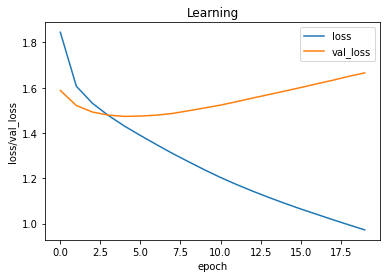

In [43]:
loss = history_dot.history['loss']
val_loss = history_dot.history['val_loss']
epoch = 20
plt.xlabel('epoch')
plt.ylabel('loss/val_loss')
plt.title('Learning')
plt.plot(range(epoch), loss, label = "loss")
plt.plot(range(epoch), val_loss, label = "val_loss")
plt.legend()


In [44]:
model_vanilla.summary()

Model: "Encoder_Decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encode_model (Encoder)      multiple                  4225924   
                                                                 
 Decode_Attention (Decoder)  multiple                  4215024   
                                                                 
 dense_2 (Dense)             multiple                  15182748  
                                                                 
Total params: 23,623,696
Trainable params: 23,623,696
Non-trainable params: 0
_________________________________________________________________


In [45]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    sentence = sentence.split(" ")
    predicted_sentence = predicted_sentence.split(" ")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)



    plt.show()

In [73]:
def predict(input_test_sentence):

    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
    E. Call plot_attention(#params)
    F. Return the predicted sentence
    '''
    ENCODER_SEQ_LEN = 27
    DECODER_SEQ_LEN = 27 
    nums = tknizer_q.texts_to_sequences([input_test_sentence])
    nums_padded = pad_sequences(nums, maxlen=27, dtype='int32', padding='post')
    encoder_output, enc_state_h, enc_state_c = model_vanilla.layers[0](nums_padded)
    pred, alphas = [], []
    cur_vec = np.zeros((1, 1))+1
    states_values = [enc_state_h, enc_state_c]
    for i in range(DECODER_SEQ_LEN):
        cur_emb = model_vanilla.layers[1].embedding(cur_vec)
        output, state_h, state_c = model_vanilla.layers[1].LSTM(cur_emb, initial_state=states_values) 
        infe_output = model_vanilla.layers[2](output)
        states_values = [state_h, state_c]  
         
        cur_vec = np.reshape(np.argmax(output), (1, 1)) 
        print(f"at time step {i} the word is ", cur_vec)
        
        
        if a_idx_word[cur_vec[0][0]] == '<end>':
            break
        pred.append(cur_vec)
        
        
     
    pred_string = ""

    pred_string = " ".join([a_idx_word[i[0][0]] for i in pred]) + " <end>"
    
    print("PREDICTED STRING:",pred_string)

    
    return  input_test_sentence, pred_string

In [63]:
max(a_idx_word.keys())

29595

In [64]:
len(a_idx_word.keys())

29595

In [74]:
index = 200
input_test_sentence = validation["question"].values[index]
actual = validation["answer_out"].values[index]
input_sentence, pred_string = predict(input_test_sentence)
import re
print(f"Input_sentence: {input_sentence}")
print(f"English predict: {pred_string}")
print(f"English actual: {re.sub('<end>', '', actual).strip()}")

at time step 0 the word is  [[253]]
at time step 1 the word is  [[455]]
at time step 2 the word is  [[7]]
at time step 3 the word is  [[73]]
at time step 4 the word is  [[80]]
at time step 5 the word is  [[40]]
at time step 6 the word is  [[111]]
at time step 7 the word is  [[28]]
at time step 8 the word is  [[297]]
at time step 9 the word is  [[448]]
at time step 10 the word is  [[344]]
at time step 11 the word is  [[78]]
at time step 12 the word is  [[496]]
at time step 13 the word is  [[93]]
at time step 14 the word is  [[85]]
at time step 15 the word is  [[93]]
at time step 16 the word is  [[496]]
at time step 17 the word is  [[389]]
at time step 18 the word is  [[267]]
at time step 19 the word is  [[297]]
at time step 20 the word is  [[31]]
at time step 21 the word is  [[77]]
at time step 22 the word is  [[125]]
at time step 23 the word is  [[78]]
at time step 24 the word is  [[496]]
at time step 25 the word is  [[284]]
at time step 26 the word is  [[161]]
PREDICTED STRING: knew d

In [76]:
index = 450

input_test_sentence = validation["question"].values[index]
actual = validation["answer_out"].values[index]
input_sentence, pred_string = predict(input_test_sentence)
import re
print(f"Input_sentence: {input_sentence}")
print(f"English predict: {re.sub('<end>', '', pred_string).strip()}")
print(f"English actual: {re.sub('<end>', '', actual).strip()}")

at time step 0 the word is  [[338]]
at time step 1 the word is  [[139]]
at time step 2 the word is  [[296]]
at time step 3 the word is  [[37]]
at time step 4 the word is  [[496]]
at time step 5 the word is  [[152]]
at time step 6 the word is  [[136]]
at time step 7 the word is  [[7]]
at time step 8 the word is  [[16]]
at time step 9 the word is  [[184]]
at time step 10 the word is  [[184]]
at time step 11 the word is  [[144]]
at time step 12 the word is  [[119]]
at time step 13 the word is  [[7]]
at time step 14 the word is  [[31]]
at time step 15 the word is  [[77]]
at time step 16 the word is  [[313]]
at time step 17 the word is  [[318]]
at time step 18 the word is  [[43]]
at time step 19 the word is  [[49]]
at time step 20 the word is  [[371]]
at time step 21 the word is  [[371]]
at time step 22 the word is  [[139]]
at time step 23 the word is  [[161]]
at time step 24 the word is  [[37]]
at time step 25 the word is  [[55]]
at time step 26 the word is  [[68]]
PREDICTED STRING: die fi

## Completely Gibberish results

In [ ]:
    ques_vocab_size = vocab_size_q + 1 #29704
    ans_vocab_size = vocab_size_a + 1 #29595
    encoder_input_length = 27
    dencoder_input_length = 27
    lstm_units = 512
    embedding_dim = 100